## Conte-Freesurfer release - MRIQC summary tables and figures
AUTHOR : Mike Tyszka  
PLACE  : Caltech Brain Imaging Center  
DATES  : 2021-05-03 JMT From scratch  

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import bids
bids.config.set_option('extension_initial_dot', True)

In [5]:
# Load group BOLD summary table (TSV)
df = pd.read_csv('group_bold.tsv', sep='\t')
df.columns

Index(['bids_name', 'aor', 'aqi', 'dummy_trs', 'dvars_nstd', 'dvars_std',
       'dvars_vstd', 'efc', 'fber', 'fd_mean', 'fd_num', 'fd_perc', 'fwhm_avg',
       'fwhm_x', 'fwhm_y', 'fwhm_z', 'gcor', 'gsr_x', 'gsr_y', 'size_t',
       'size_x', 'size_y', 'size_z', 'snr', 'spacing_tr', 'spacing_x',
       'spacing_y', 'spacing_z', 'summary_bg_k', 'summary_bg_mad',
       'summary_bg_mean', 'summary_bg_median', 'summary_bg_n',
       'summary_bg_p05', 'summary_bg_p95', 'summary_bg_stdv', 'summary_fg_k',
       'summary_fg_mad', 'summary_fg_mean', 'summary_fg_median',
       'summary_fg_n', 'summary_fg_p05', 'summary_fg_p95', 'summary_fg_stdv',
       'tsnr'],
      dtype='object')

In [6]:
# Parse filename for BIDS keys (subject, session, etc)
subject_list = []
session_list = []
task_list = []
run_list = []

for rc, row in bold_df.iterrows():
    
    # pybids needs a leading directory separator 
    fname = os.path.sep + row['bids_name']
    keys = bids.layout.parse_file_entities(fname)
    
    subject_list.append(keys['subject'])
    session_list.append(keys['session'])
    task_list.append(keys['task'])
    run_list.append(keys['run'])
    
df['Subject'] = pd.Series(subject_list, index=bold_df.index)
df['Protocol'] = pd.Series(session_list, index=bold_df.index)
df['Task'] = pd.Series(task_list, index=bold_df.index)
df['Run'] = pd.Series(run_list, index=bold_df.index)

## Apply Exclusion Criteria

In [7]:
# Exclude subjects not in FS7 group

# Complete subject list
raw_subj_list = df['Subject'].unique()

# Load FS7 subject list (note 'sub-' prefix used in this file)
fs_subj_df = pd.read_csv('FS7_pass0_subjects.csv', header=None, names=['Subject'])
fs_subj_list = fs_subj_df['Subject'].values

print('Excluding subjects not in FS7 group:')
for subj_id in raw_subj_list:
    full_subj_id = 'sub-' + subj_id
    if full_subj_id not in fs_subj_list:
        print('  {}'.format(subj_id))
        df.drop(index=df[df['Subject'] == subj_id].index, inplace=True)
        
# Exclude unused tasks and sessions
df.drop(df[df['Protocol'] == 'coresocbat'].index, inplace=True)
df.drop(df[df['Task'] == 'loi'].index, inplace=True)
df.drop(df[df['Task'] == 'loi3'].index, inplace=True)
df.drop(df[df['Task'] == 'socnsloi2'].index, inplace=True)

Excluding subjects not in FS7 group:
  CC0084
  CC0088
  CC0092


In [8]:
# Create columns for vox volume and tSNR normalized by 1 / (V * sqrt(TR))
df['Voxel Volume (ul)'] = df.apply(lambda row: row['spacing_x'] * row['spacing_y'] * row['spacing_z'], axis='columns')
df['tSNR Norm'] = df.apply(lambda row: row['tsnr'] / (row['Voxel Volume (ul)'] * np.sqrt(row['spacing_tr'])), axis='columns')

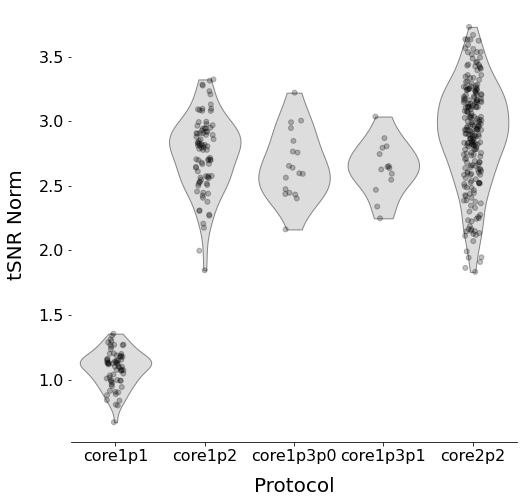

In [40]:
# Normalized tSNR by session
fig, ax = plt.subplots(figsize=(8, 8))

ordered = sorted(df['Protocol'].unique())

sns.violinplot(
    x='Protocol',
    y='tSNR Norm',
    data=df,
    cut=0,
    scale='width',
    inner=None,
    linewidth=1,
    color='#DDDDDD',
    saturation=1,
    order=ordered,
    ax=ax)

sns.stripplot(
    x='Protocol',
    y='tSNR Norm',
    data=df,
    jitter=True,
    linewidth=1,
    color='#050505',
    alpha=0.25,
    order=ordered,
    ax=ax)

sns.despine(left=True)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.xaxis.label.set_size(20)
ax.xaxis.set_label_coords(0.5, -0.08)
ax.yaxis.label.set_size(20)
ax.yaxis.set_label_coords(-0.1, 0.5)

plt.savefig('BOLD_Norm_tSNR.png', dpi=300)
plt.show()